# Experiment Management with MLFlow

This tutorial shows how to use common MLFlow functionalities to management MONAI experiments. The MONAI example used here is [3D spleen segmentation](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb).

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

`MLFlow` comes as part of the `monai[all]` installation. For official documentation on MLFlow's experiment management functionalities, click [here](https://www.mlflow.org/docs/latest/tracking.html).

We use `plotly` to generate interactive 3D visualizations, and we include relevant code below. You can find official documentations [here](https://plotly.com/python/). You are welcome to remove it if it's not desired, or replace it with your own preferred method of visualization. Note that MLFlow doesn't directly handle the visualizations; rather, it tracks "artifacts," which in effect can be any of a wide range of files. You can reference the usage in this tutorial.

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import plotly" || pip install plotly==5.9.0
%matplotlib inline

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import mlflow
import plotly.graph_objects as go
import math
import numpy as np

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set up MLFlow tracking

**This is a very important cell for tracking. If this is your first time using this, please read the following description in its entirety before proceeding.**

For ease of use, we set up tracking locally. There are other options available, some of which are remote; find them [here](https://www.mlflow.org/docs/latest/tracking.html#where-runs-are-recorded).

You can specify an `experiment_name` and a `run_name`. In the sample interface shown below, `experiment_name` is used to organize the tabs on the left (e.g., "Experiment 1"), while `run_name` is used to organize the chart within each tab (e.g., "test" and "test2").

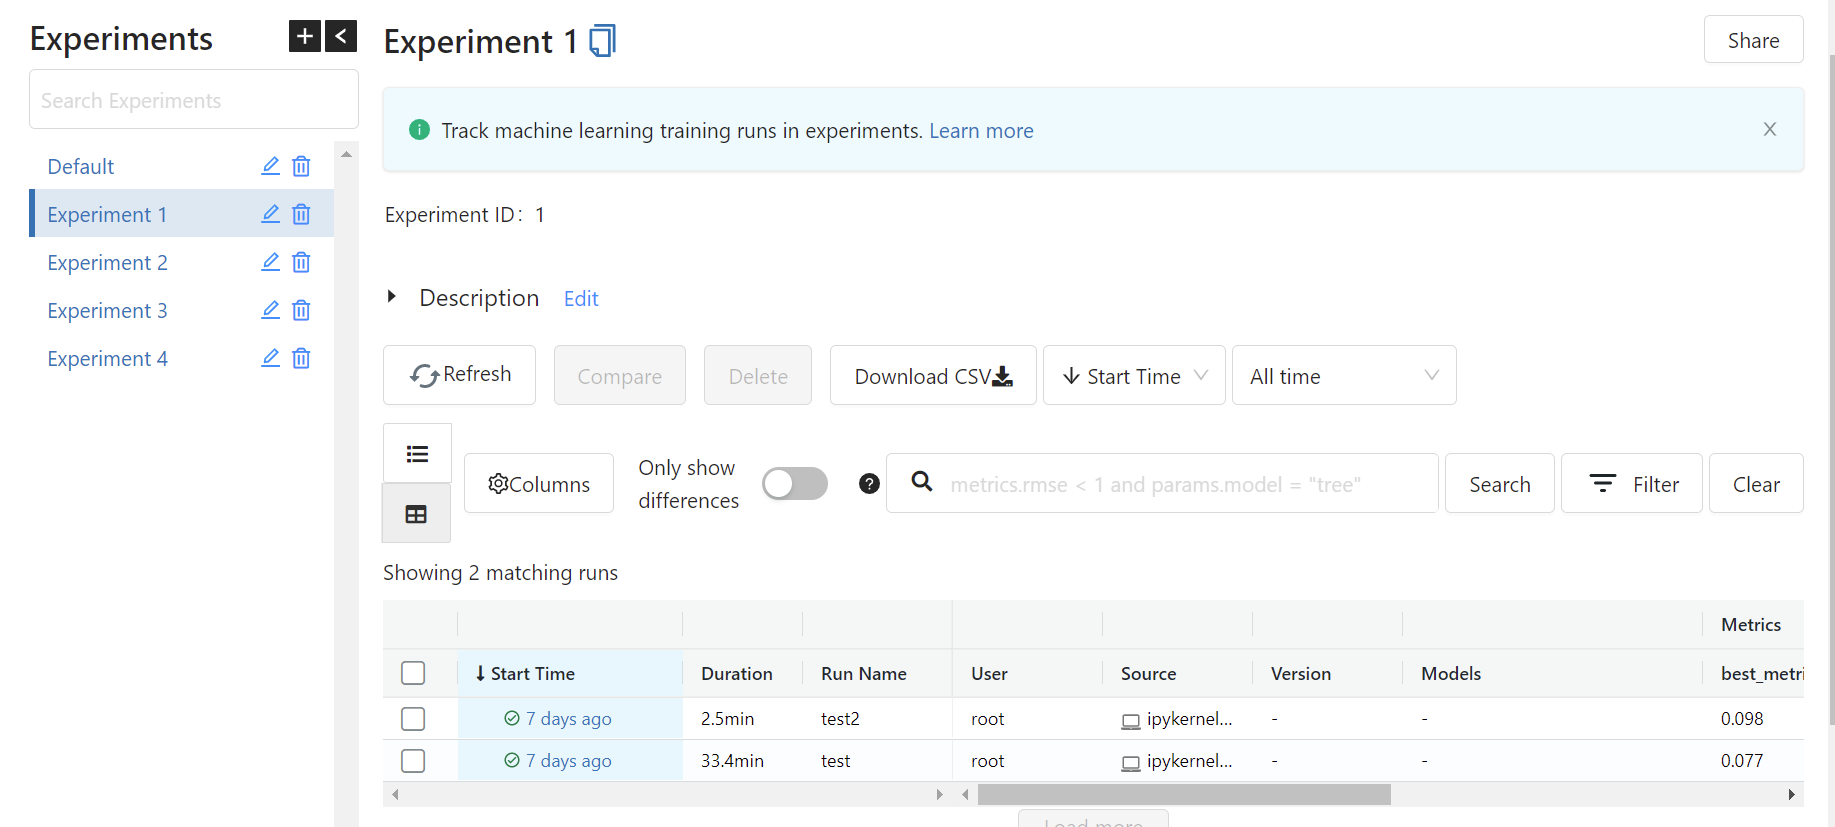

`set_experiment` will automatically place the current experiment-run in its appropriate location, creating a new experiment if necessary.

MLFlow does not currently have support for auto-logging in regular PyTorch, so we will log the run manually. Here we start the run; note that it is best practice to end the run after you finish this experiment (the code is provided at the very end).

In [ ]:
experiment_name = 'Spleen 3D segmentation 7'
run_name = 'test8'
experiment = mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## Sample visualization to be included in Aim

This cell is needed and only needed for plotly visualizations. It contains some helper functions. If you run this cell, you will see an example of what the 3D visualizations look like.

If you get a shape mismatch error, it may have to do with the size of your image. Changing `number_of_frames` or `sampling_rate` in `plotly_3d_figure` might solve the problem.

Here is a sample visualization with Plotly. It is an interactive visualization where you can drag the slider to view different slices of the same scan.
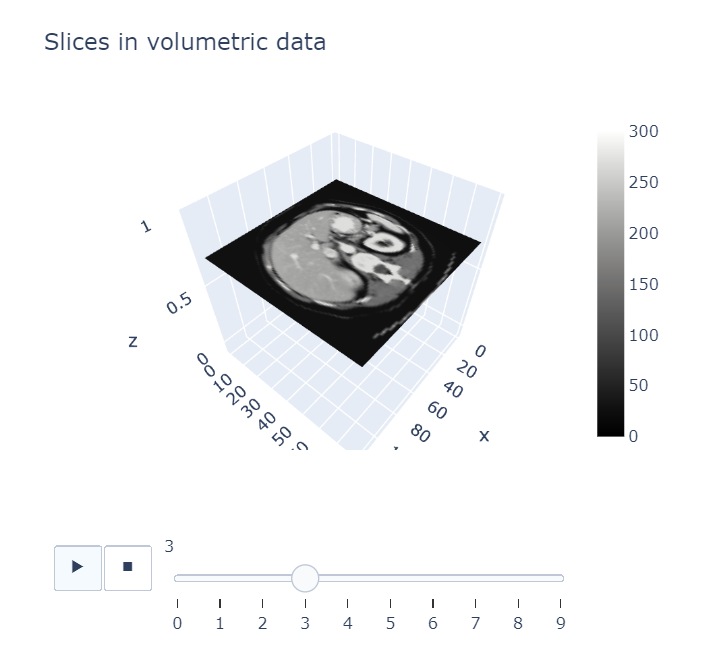

In [ ]:
def bin_ndarray(ndarray, new_shape, operation='mean'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c // d) for d, c in zip(new_shape,
                                                     ndarray.shape)]
    flattened = [num for p in compression_pairs for num in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1 * (i + 1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1 * (i + 1))
    return ndarray


def closest_shapes_up(shapes, dims, pad_factor=10):
    new_shape = [shapes[i] for i in range(len(shapes))]
    for dim in dims:
        new_shape[dim] = closest_number_up(shapes[dim], pad_factor)

    return new_shape


def closest_number_up(n, m):
    # Find the quotient
    q = int(n / m)

    if (n * m) > 0:
        closest_up = (m * (q + 1))
    else:
        closest_up = (m * (q - 1))

    return closest_up


def pad_ndarray(ndarray, new_shape):
    result = np.zeros(new_shape)
    result[:ndarray.shape[0], :ndarray.shape[1], :ndarray.shape[2]] = ndarray
    return result


def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear"},
    }


def plotly_3d_figure(volume, number_of_frames, sampling_rate=2, padding_factor=10):

    volume = (volume.T * 255).float()
    nb_frames = number_of_frames
    frame_ratio = nb_frames / 10

    original_frames = len(volume)
    frame_subsample_rate = math.ceil(original_frames / nb_frames)

    volume = volume[::frame_subsample_rate]

    pad_shape = closest_shapes_up(volume.shape, dims=(1, 2), pad_factor=padding_factor)
    volume = pad_ndarray(volume, pad_shape)
    r, c = volume[0].shape
    volume = bin_ndarray(volume, (nb_frames, int(r / sampling_rate), int(c / sampling_rate)))
    r, c = volume[0].shape

    fig = go.Figure(frames=[go.Frame(data=go.Surface(
        z=(frame_ratio - k * 0.1) * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames - 1 - k]),
        cmin=0, cmax=300
    ),
        name=str(k)  # you need to name the frame for the animation to behave properly
    )
        for k in range(nb_frames)])

    # Add data to be displayed before animation starts
    fig.add_trace(go.Surface(
        z=frame_ratio * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames - 1]),
        colorscale='Gray',
        cmin=0, cmax=300,
        colorbar=dict(thickness=20, ticklen=4)
    ))

    sliders = [
        {
            "pad": {"b": 10, "t": 60},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {
                    "args": [[f.name], frame_args(0)],
                    "label": str(k),
                    "method": "animate",
                }
                for k, f in enumerate(fig.frames)
            ],
        }
    ]

    # Layout
    fig.update_layout(
        title='Slices in volumetric data',
        width=500,
        height=500,
        scene=dict(
            zaxis=dict(range=[-0.1, frame_ratio], autorange=False),
            aspectmode='auto',
            aspectratio=dict(x=1, y=1, z=1),
        ),
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, frame_args(1)],
                        "label": "&#9654;",  # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;",  # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
        sliders=sliders
    )

    return fig

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
vol = check_data["image"][0][0]
fig = plotly_3d_figure(vol, number_of_frames=10, sampling_rate=2)
fig.show()

## Define CacheDataset and DataLoader for training and validation

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

## Create Model, Loss, Optimizer

There are three main types of logging in MLFlow:
- `log_param` and `log_params`, for logging anything that is "onetime" for each experiment-run, including model parameters and other hyperparameters. **An error will be thrown if the same parameter name is logged more than once in the same run.**
- `log_metric` and `log_metrics`, for logging numerical values during training. **Epoch numbers need to be specified**; otherwise, MLFlow will report a conflict error.
- `log_artifact` and `log_artifacts`, for logging files that will be associated with this experiment-run.

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

# easily save all model arguments
UNet_metadata = dict(spatial_dims=3,
                     in_channels=1,
                     out_channels=2,
                     channels=(16, 32, 64, 128, 256),
                     strides=(2, 2, 2, 2),
                     num_res_units=2,
                     norm=Norm.BATCH)
model = UNet(**UNet_metadata).to(device)
mlflow.log_params(UNet_metadata)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

mlflow.log_param('optimizer', 'Adam')

## Train with tracking

You can open a terminal in the same directory and run `mlflow ui &` (if there is a port conflict, use `--port` to specify a different one) to see the tracking UI. By default, the address will be `http://127.0.0.1:5000`. Note that the run does not have to be ended for you to open the UI. If you get an error saying "address already in use," you may have attempted to open up Aim multiple times. In that case, you can specify a different port number using `aim up --port xxxxx &`.

In the figure below, we show the three main types of information that can be tracked: parameters, metrics, and artifacts.

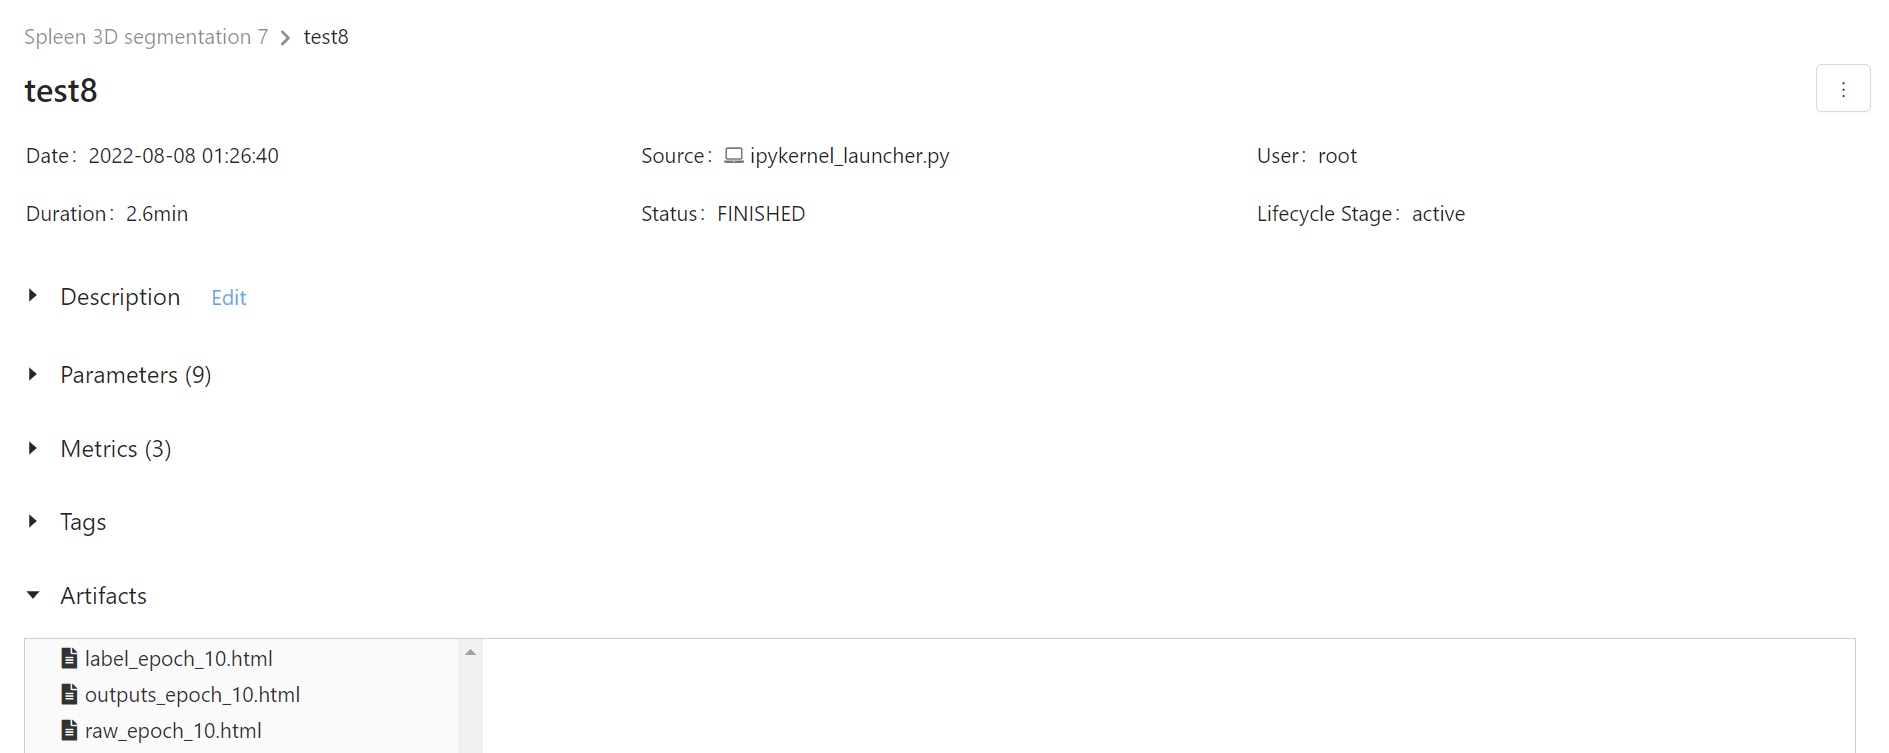

<table><tr>
<td> 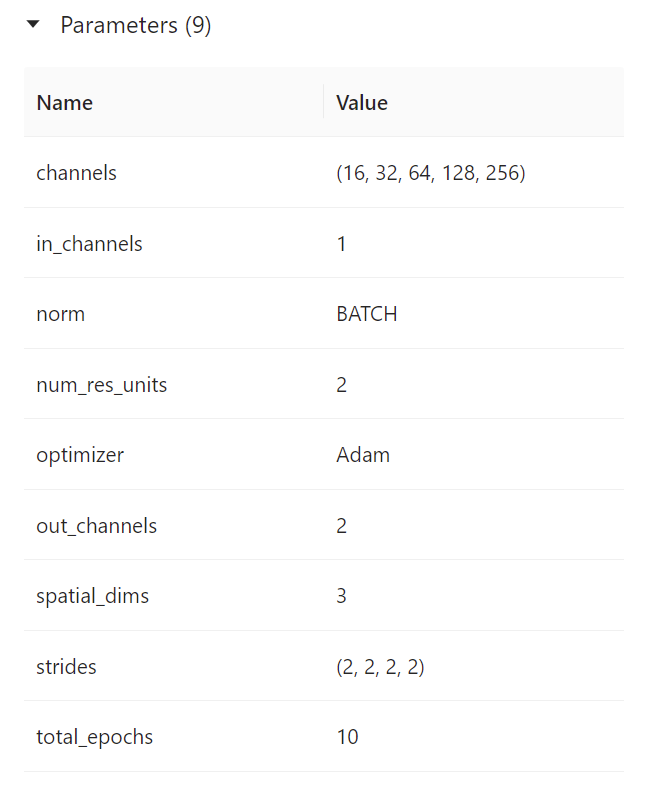 </td>
<td> 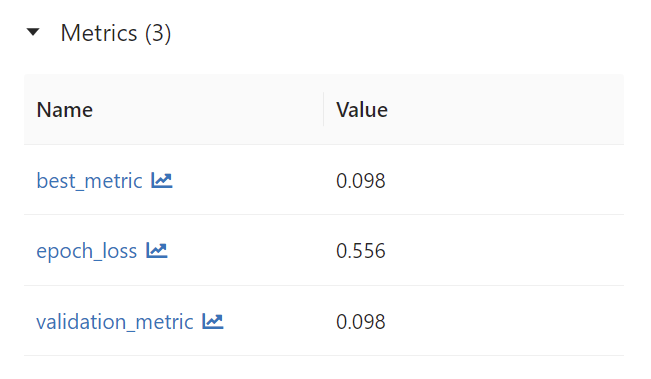 </td> 
</tr></table>

Note that the 3D plotly visualizations can take up a non-trivial amount of disc space and use a non-trivial amount of time. If you only want the final result, set `save_visual_every` equal to `max_epochs`. 

We have placed saving 3D visualizations within validation for now, so `save_visual_every` also needs to be divisible by `val_interval`, but you can customize its usage to your needs.

In [ ]:
# the original segmentation was run with 600 steps; to see a quick example, use 10 steps
max_epochs = 10
val_interval = 2
# use this to specify how often you want to save 3D visualizations
save_visual_every = 10
mlflow.log_param('total_epochs', max_epochs)

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# logged artifacts will be stored in the local mlruns/ folder, we are using this as a tmp workspace
plotly_tmp_dir = tempfile.mkdtemp()

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    mlflow.log_metric(key='epoch_loss', value=epoch_loss, step=epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # log visuals
            if (epoch + 1) % save_visual_every == 0:
                print('tracking plotly...', end='')
                fig_raw = plotly_3d_figure(val_inputs[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                fig_raw.write_html(os.path.join(plotly_tmp_dir, f'raw_epoch_{epoch+1}.html'))
                mlflow.log_artifact(os.path.join(plotly_tmp_dir, f'raw_epoch_{epoch+1}.html'))
                fig_label = plotly_3d_figure(val_labels[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                fig_label.write_html(os.path.join(plotly_tmp_dir, f'label_epoch_{epoch+1}.html'))
                mlflow.log_artifact(os.path.join(plotly_tmp_dir, f'label_epoch_{epoch+1}.html'))
                fig_outputs = plotly_3d_figure(val_outputs[0][0].cpu(), number_of_frames=101, sampling_rate=5)
                fig_outputs.write_html(os.path.join(plotly_tmp_dir, f'outputs_epoch_{epoch+1}.html'))
                mlflow.log_artifact(os.path.join(plotly_tmp_dir, f'outputs_epoch_{epoch+1}.html'))
                print('done.')

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            mlflow.log_metric(key='validation_metric', value=metric, step=epoch + 1)
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            mlflow.log_metric(key='best_metric', value=best_metric, step=epoch + 1)
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

Under "Metrics" shown in the previous figure, you can click on the hyperlink and see plots of loss and metric against steps. The graph would appear similar to what you can get from matplotlib.
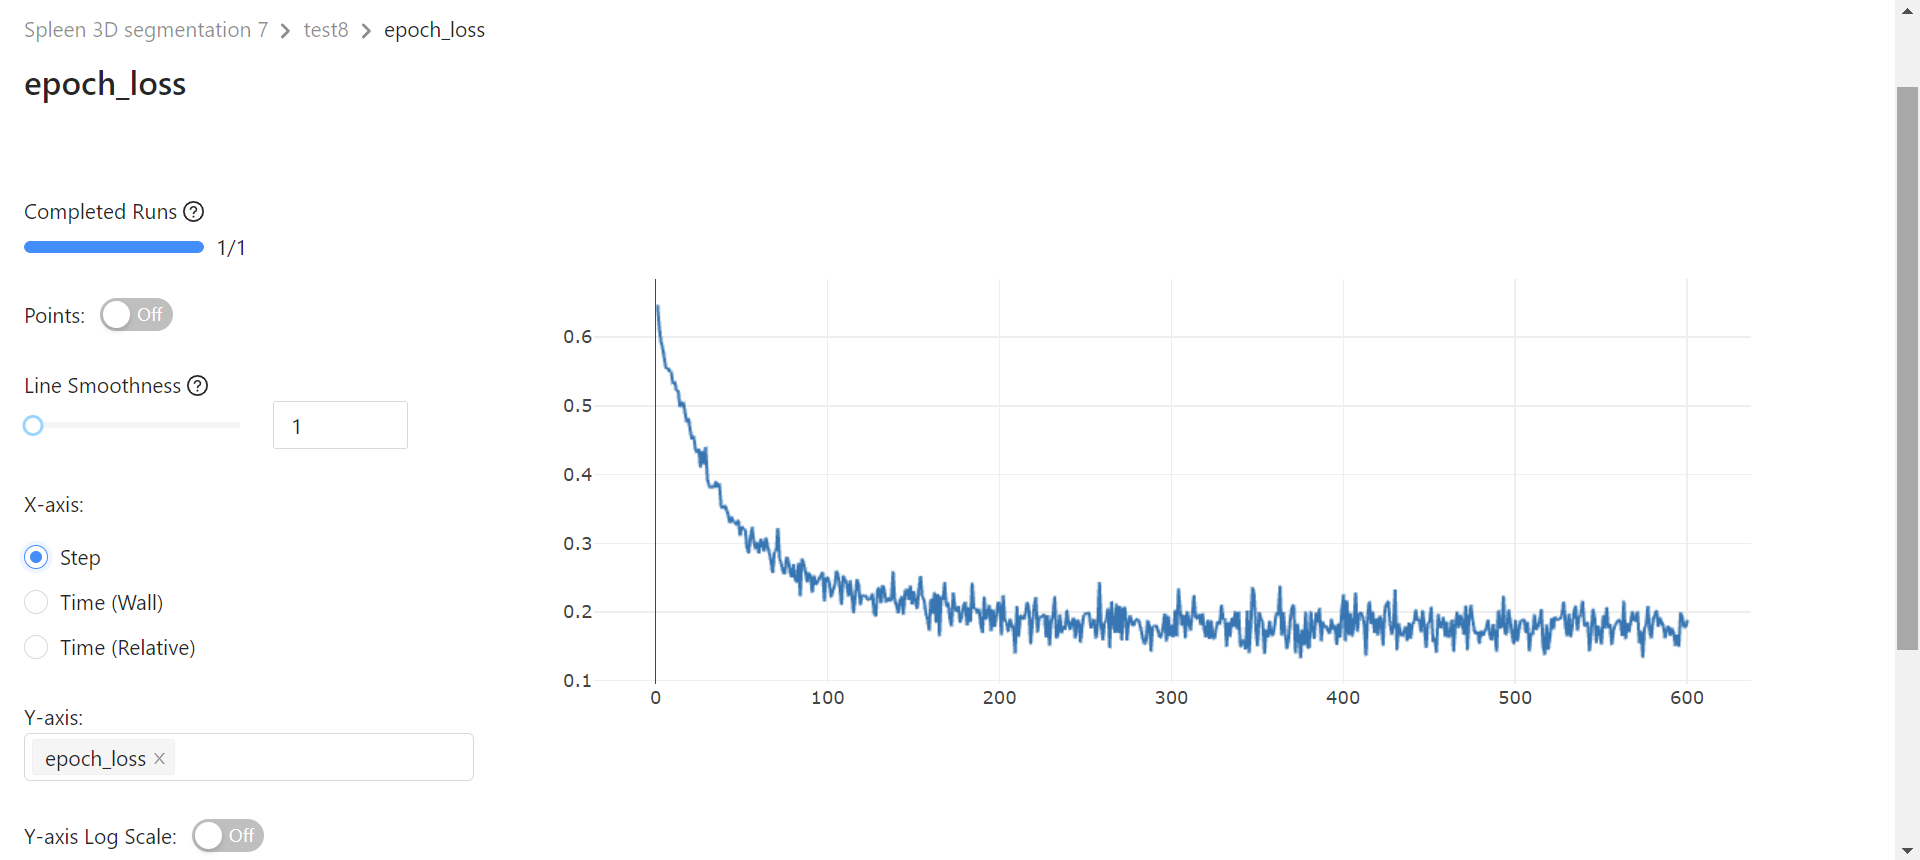
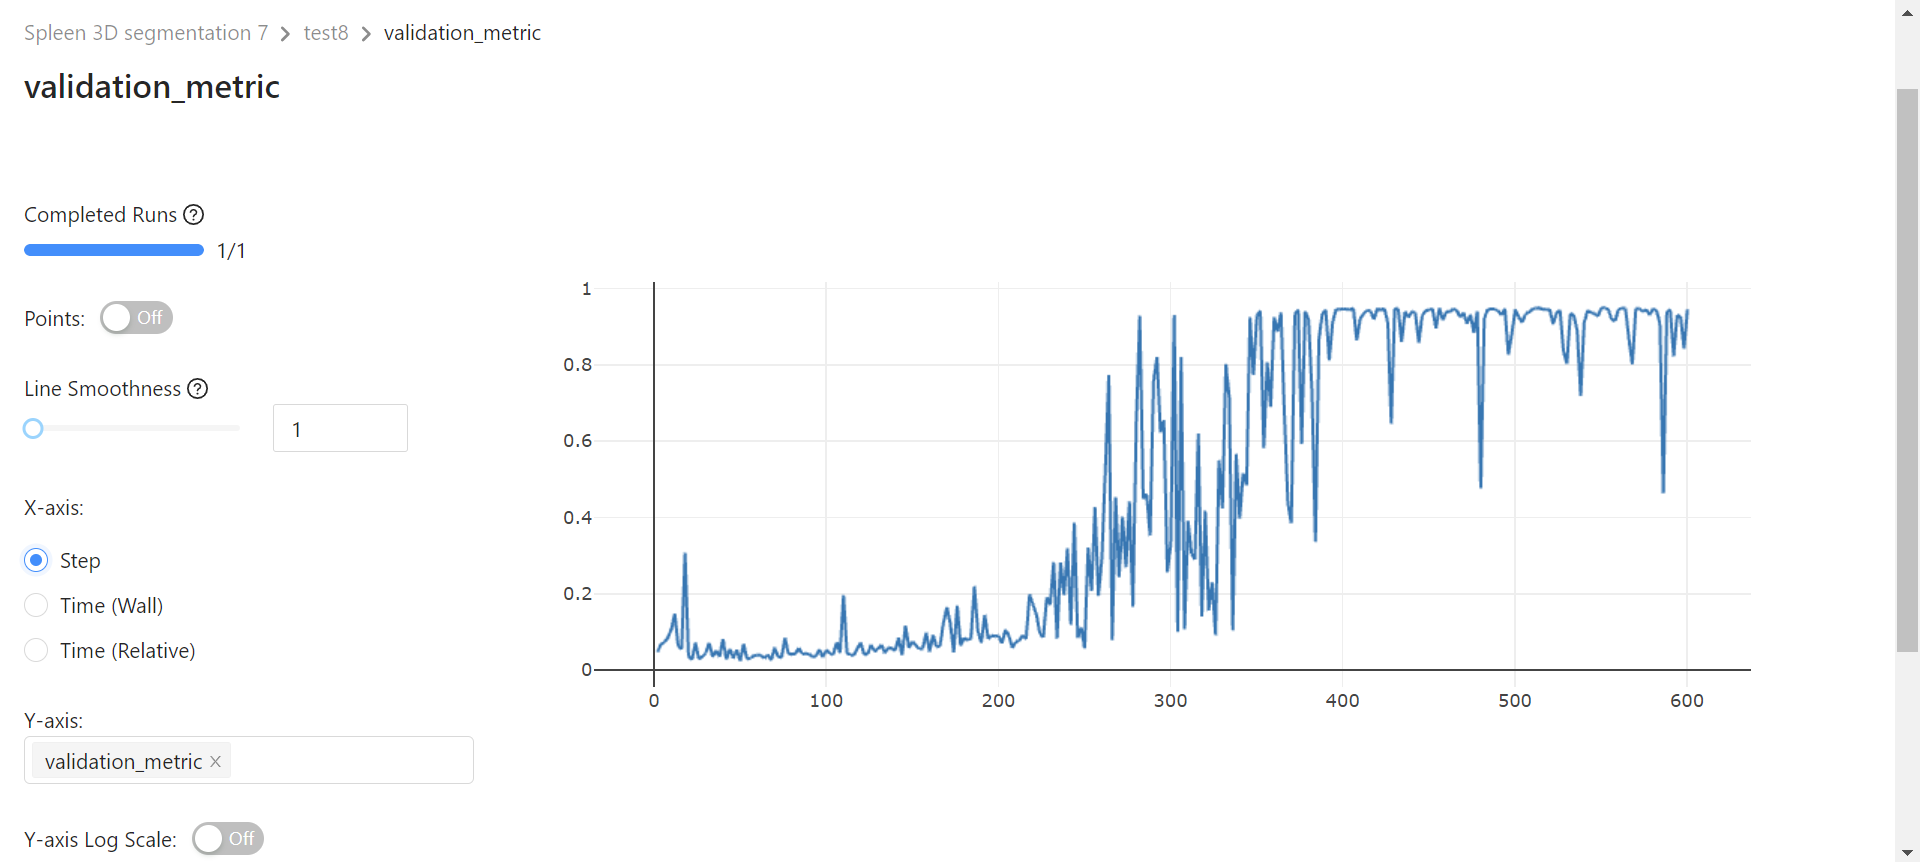

## End tracking and clean up data directory

Here, we end the MLFlow run. Remove directory if a temporary was used.

In [ ]:
mlflow.end_run()

if directory is None:
    shutil.rmtree(root_dir)
    
shutil.rmtree(plotly_tmp_dir)